# Comparison


In [1]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [2]:
from scripts.params import get_params

params = get_params()

In [3]:
from scripts.epftoolbox_dm_gw import DM, plot_multivariate_DM_test, GW, plot_multivariate_GW_test

In [4]:
dataroute = os.path.join("..", "data")
dumproute = os.path.join("..", "dump")
resultsroute = os.path.join("..", "results")
graphsroute = os.path.join(resultsroute, "graphs")

In [5]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [6]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)

In [7]:
def get_all_results_matching(substring:str):
    all_results = {}

    for filename in os.listdir(resultsroute):
        file_path = os.path.join(resultsroute, filename)
        if os.path.isfile(file_path) and substring in filename:
            all_results[filename] = file_path

    print(all_results)
    return all_results

In [8]:
all_forecasts = get_all_results_matching("forecast")
all_residuals = get_all_results_matching("residual")

{'GARCH_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\GARCH_AR_^MERV_aic_best_forecasts.pickle', 'GARCH_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\GARCH_AR_^MERV_bic_best_forecasts.pickle', 'HMM_multiv_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\HMM_multiv_AR_^MERV_aic_best_forecasts.pickle', 'HMM_multiv_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\HMM_multiv_AR_^MERV_bic_best_forecasts.pickle', 'HMM_univ_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\HMM_univ_AR_^MERV_aic_best_forecasts.pickle', 'HMM_univ_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\HMM_univ_AR_^MERV_bic_best_forecasts.pickle', 'HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle', 'HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle', 'VAR_multiv_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\VAR_multiv_AR_^MERV_aic_best_forecasts.pickle', 'VAR_multiv_AR_^MERV

In [9]:
def get_only_log_rets(dict_with_dfs: dict, stock: str):
    if type(dict_with_dfs[stock]) == pd.Series:
        # univariate models are saved as series
        df = pd.DataFrame(dict_with_dfs[stock])

    else:
        try:
            # multivariate models are saved as dataframes
            df = pd.DataFrame(dict_with_dfs[stock][f"{stock}_log_rets"])
        except:  # TODO: SACAR ESTO! Es un chanchullo pq hay algunas que son guardadas como None
            pass
    return df

In [10]:
def create_df_from_results_dict(results_dict:dict, substring_to_replace:str):
    created_df = pd.DataFrame()

    for name, dir in results_dict.items():
        dict_with_dfs = pd.read_pickle(dir)
        print(name)

        for stock in dict_with_dfs.keys():
            df = get_only_log_rets(dict_with_dfs, stock)

            modelname = (
                name.replace(f"{substring_to_replace}.pickle", "")
                .replace("best", "")
                .replace(params["tablename"], "")
                .replace("__", "_")
                .replace("__", "_")
            )

            df.columns = [modelname + "_" + stock]

            created_df = pd.merge(
                created_df, df, left_index=True, right_index=True, how="outer"
            )

    created_df.index = pd.to_datetime(created_df.index)
    created_df = created_df[created_df.index > start_test]
    return created_df

In [11]:
forecasts_df = create_df_from_results_dict(all_forecasts, "forecasts")
forecasts_df.head(2)

GARCH_AR_^MERV_aic_best_forecasts.pickle
GARCH_AR_^MERV_bic_best_forecasts.pickle
HMM_multiv_AR_^MERV_aic_best_forecasts.pickle
HMM_multiv_AR_^MERV_bic_best_forecasts.pickle
HMM_univ_AR_^MERV_aic_best_forecasts.pickle
HMM_univ_AR_^MERV_bic_best_forecasts.pickle
HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle
HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle
VAR_multiv_AR_^MERV_aic_best_forecasts.pickle
VAR_multiv_AR_^MERV_bic_best_forecasts.pickle
VAR_with_vol_AR_^MERV_aic_best_forecasts.pickle
VAR_with_vol_AR_^MERV_bic_best_forecasts.pickle


,GARCH_aic__^MERV,GARCH_aic__GGAL.BA,GARCH_aic__GGAL,GARCH_aic__YPFD.BA,GARCH_aic__YPF,GARCH_aic__EDN.BA,GARCH_aic__EDN,GARCH_aic__BMA.BA,GARCH_aic__BMA,GARCH_aic__BBAR.BA,GARCH_aic__BBAR,GARCH_bic__^MERV,GARCH_bic__GGAL.BA,GARCH_bic__GGAL,GARCH_bic__YPFD.BA,GARCH_bic__YPF,GARCH_bic__EDN.BA,GARCH_bic__EDN,GARCH_bic__BMA.BA,GARCH_bic__BMA,GARCH_bic__BBAR.BA,GARCH_bic__BBAR,HMM_multiv_aic__^MERV,HMM_multiv_aic__GGAL.BA,HMM_multiv_aic__GGAL,HMM_multiv_aic__YPFD.BA,HMM_multiv_aic__YPF,HMM_multiv_aic__EDN.BA,HMM_multiv_aic__EDN,HMM_multiv_aic__BMA.BA,HMM_multiv_aic__BMA,HMM_multiv_aic__BBAR.BA,HMM_multiv_aic__BBAR,HMM_multiv_bic__^MERV,HMM_multiv_bic__GGAL.BA,HMM_multiv_bic__GGAL,HMM_multiv_bic__YPFD.BA,HMM_multiv_bic__YPF,HMM_multiv_bic__EDN.BA,HMM_multiv_bic__EDN,HMM_multiv_bic__BMA.BA,HMM_multiv_bic__BMA,HMM_multiv_bic__BBAR.BA,HMM_multiv_bic__BBAR,HMM_univ_aic__^MERV,HMM_univ_aic__GGAL.BA,HMM_univ_aic__GGAL,HMM_univ_aic__YPFD.BA,HMM_univ_aic__YPF,HMM_univ_aic__EDN.BA,HMM_univ_aic__EDN,HMM_univ_aic__BMA.BA,HMM_univ_aic__BMA,HMM_univ_aic__BBAR.BA,HMM_univ_aic__BBAR,HMM_univ_bic__^MERV,HMM_univ_bic__GGAL.BA,HMM_univ_bic__GGAL,HMM_univ_bic__YPFD.BA,HMM_univ_bic__YPF,HMM_univ_bic__EDN.BA,HMM_univ_bic__EDN,HMM_univ_bic__BMA.BA,HMM_univ_bic__BMA,HMM_univ_bic__BBAR.BA,HMM_univ_bic__BBAR,HMM_with_vol_aic__^MERV,HMM_with_vol_aic__GGAL.BA,HMM_with_vol_aic__GGAL,HMM_with_vol_aic__YPFD.BA,HMM_with_vol_aic__YPF,HMM_with_vol_aic__EDN.BA,HMM_with_vol_aic__EDN,HMM_with_vol_aic__BMA.BA,HMM_with_vol_aic__BMA,HMM_with_vol_aic__BBAR.BA,HMM_with_vol_aic__BBAR,HMM_with_vol_bic__^MERV,HMM_with_vol_bic__GGAL.BA,HMM_with_vol_bic__GGAL,HMM_with_vol_bic__YPFD.BA,HMM_with_vol_bic__YPF,HMM_with_vol_bic__EDN.BA,HMM_with_vol_bic__EDN,HMM_with_vol_bic__BMA.BA,HMM_with_vol_bic__BMA,HMM_with_vol_bic__BBAR.BA,HMM_with_vol_bic__BBAR,VAR_multiv_aic__^MERV,VAR_multiv_aic__GGAL.BA,VAR_multiv_aic__GGAL,VAR_multiv_aic__YPFD.BA,VAR_multiv_aic__YPF,VAR_multiv_aic__EDN.BA,VAR_multiv_aic__EDN,VAR_multiv_aic__BMA.BA,VAR_multiv_aic__BMA,VAR_multiv_aic__BBAR.BA,VAR_multiv_aic__BBAR,VAR_multiv_bic__^MERV,VAR_multiv_bic__GGAL.BA,VAR_multiv_bic__GGAL,VAR_multiv_bic__YPFD.BA,VAR_multiv_bic__YPF,VAR_multiv_bic__EDN.BA,VAR_multiv_bic__EDN,VAR_multiv_bic__BMA.BA,VAR_multiv_bic__BMA,VAR_multiv_bic__BBAR.BA,VAR_multiv_bic__BBAR,VAR_with_vol_aic__^MERV,VAR_with_vol_aic__GGAL.BA,VAR_with_vol_aic__GGAL,VAR_with_vol_aic__YPFD.BA,VAR_with_vol_aic__YPF,VAR_with_vol_aic__EDN.BA,VAR_with_vol_aic__EDN,VAR_with_vol_aic__BMA.BA,VAR_with_vol_aic__BMA,VAR_with_vol_aic__BBAR.BA,VAR_with_vol_aic__BBAR,VAR_with_vol_bic__^MERV,VAR_with_vol_bic__GGAL.BA,VAR_with_vol_bic__GGAL,VAR_with_vol_bic__YPFD.BA,VAR_with_vol_bic__YPF,VAR_with_vol_bic__EDN.BA,VAR_with_vol_bic__EDN,VAR_with_vol_bic__BMA.BA,VAR_with_vol_bic__BMA,VAR_with_vol_bic__BBAR.BA,VAR_with_vol_bic__BBAR
2023-06-01,0.006464,0.003662,0.002645,0.008487,0.004440,0.008652,-0.000993,0.003256,-0.000135,0.005759,0.001840,0.006464,0.003929,0.002719,0.008337,0.004196,0.008652,-0.001204,0.002898,-0.000152,0.005987,0.001814,NaN,0.005035,NaN,0.006915,0.003978,NaN,0.001715,0.003624,NaN,NaN,0.001957,NaN,0.005035,0.001568,0.006915,0.003978,NaN,0.001715,0.003624,0.001281,NaN,0.001957,0.005691,0.003695,0.001749,0.007938,0.002818,0.017306,0.001811,0.003097,0.001915,0.003912,0.002321,0.005691,0.002319,0.001749,0.007544,0.002818,0.006885,0.002619,0.003097,0.000191,0.003912,0.001466,0.005429,0.005197,0.001571,0.006915,0.003978,0.005376,0.004389,0.004688,0.001281,0.005251,0.001951,0.005834,0.005197,0.001568,0.006915,0.003978,0.005376,0.004389,0.004688,0.001281,0.005250,0.001951,0.00019,0.011170,-0.007891,0.009568,0.002968,0.001196,-0.004136,-0.038366,-0.023599,-0.031229,-0.017275,0.002074,0.002612,0.002179,0.001047,0.003000,0.006174,0.000013,-0.001931,-0.001257,-0.001394,-0.002392,0.004813,0.016648,-0.007634,0.001170,-0.000505,0.001122,0.002737,-0.014572,-0.007289,-0.005403,-0.006371,0.004117,0.004146,0.002526,0.002763,0.003393,0.004330,-0.000316,0.003754,0.000073,

In [12]:
residual_df = create_df_from_results_dict(all_residuals, "residuals")
residual_df.head(2)

GARCH_AR_^MERV_aic_best_residuals.pickle
GARCH_AR_^MERV_bic_best_residuals.pickle
HMM_multiv_AR_^MERV_aic_best_residuals.pickle
HMM_multiv_AR_^MERV_bic_best_residuals.pickle
HMM_univ_AR_^MERV_aic_best_residuals.pickle
HMM_univ_AR_^MERV_bic_best_residuals.pickle
HMM_with_vol_AR_^MERV_aic_best_residuals.pickle
HMM_with_vol_AR_^MERV_bic_best_residuals.pickle
VAR_multiv_AR_^MERV_aic_best_residuals.pickle
VAR_multiv_AR_^MERV_bic_best_residuals.pickle
VAR_with_vol_AR_^MERV_aic_best_residuals.pickle
VAR_with_vol_AR_^MERV_bic_best_residuals.pickle


,GARCH_aic__^MERV,GARCH_aic__GGAL.BA,GARCH_aic__GGAL,GARCH_aic__YPFD.BA,GARCH_aic__YPF,GARCH_aic__EDN.BA,GARCH_aic__EDN,GARCH_aic__BMA.BA,GARCH_aic__BMA,GARCH_aic__BBAR.BA,GARCH_aic__BBAR,GARCH_bic__^MERV,GARCH_bic__GGAL.BA,GARCH_bic__GGAL,GARCH_bic__YPFD.BA,GARCH_bic__YPF,GARCH_bic__EDN.BA,GARCH_bic__EDN,GARCH_bic__BMA.BA,GARCH_bic__BMA,GARCH_bic__BBAR.BA,GARCH_bic__BBAR,HMM_multiv_aic__^MERV,HMM_multiv_aic__GGAL.BA,HMM_multiv_aic__GGAL,HMM_multiv_aic__YPFD.BA,HMM_multiv_aic__YPF,HMM_multiv_aic__EDN.BA,HMM_multiv_aic__EDN,HMM_multiv_aic__BMA.BA,HMM_multiv_aic__BMA,HMM_multiv_aic__BBAR.BA,HMM_multiv_aic__BBAR,HMM_multiv_bic__^MERV,HMM_multiv_bic__GGAL.BA,HMM_multiv_bic__GGAL,HMM_multiv_bic__YPFD.BA,HMM_multiv_bic__YPF,HMM_multiv_bic__EDN.BA,HMM_multiv_bic__EDN,HMM_multiv_bic__BMA.BA,HMM_multiv_bic__BMA,HMM_multiv_bic__BBAR.BA,HMM_multiv_bic__BBAR,HMM_univ_aic__^MERV,HMM_univ_aic__GGAL.BA,HMM_univ_aic__GGAL,HMM_univ_aic__YPFD.BA,HMM_univ_aic__YPF,HMM_univ_aic__EDN.BA,HMM_univ_aic__EDN,HMM_univ_aic__BMA.BA,HMM_univ_aic__BMA,HMM_univ_aic__BBAR.BA,HMM_univ_aic__BBAR,HMM_univ_bic__^MERV,HMM_univ_bic__GGAL.BA,HMM_univ_bic__GGAL,HMM_univ_bic__YPFD.BA,HMM_univ_bic__YPF,HMM_univ_bic__EDN.BA,HMM_univ_bic__EDN,HMM_univ_bic__BMA.BA,HMM_univ_bic__BMA,HMM_univ_bic__BBAR.BA,HMM_univ_bic__BBAR,HMM_with_vol_aic__^MERV,HMM_with_vol_aic__GGAL.BA,HMM_with_vol_aic__GGAL,HMM_with_vol_aic__YPFD.BA,HMM_with_vol_aic__YPF,HMM_with_vol_aic__EDN.BA,HMM_with_vol_aic__EDN,HMM_with_vol_aic__BMA.BA,HMM_with_vol_aic__BMA,HMM_with_vol_aic__BBAR.BA,HMM_with_vol_aic__BBAR,HMM_with_vol_bic__^MERV,HMM_with_vol_bic__GGAL.BA,HMM_with_vol_bic__GGAL,HMM_with_vol_bic__YPFD.BA,HMM_with_vol_bic__YPF,HMM_with_vol_bic__EDN.BA,HMM_with_vol_bic__EDN,HMM_with_vol_bic__BMA.BA,HMM_with_vol_bic__BMA,HMM_with_vol_bic__BBAR.BA,HMM_with_vol_bic__BBAR,VAR_multiv_aic__^MERV,VAR_multiv_aic__GGAL.BA,VAR_multiv_aic__GGAL,VAR_multiv_aic__YPFD.BA,VAR_multiv_aic__YPF,VAR_multiv_aic__EDN.BA,VAR_multiv_aic__EDN,VAR_multiv_aic__BMA.BA,VAR_multiv_aic__BMA,VAR_multiv_aic__BBAR.BA,VAR_multiv_aic__BBAR,VAR_multiv_bic__^MERV,VAR_multiv_bic__GGAL.BA,VAR_multiv_bic__GGAL,VAR_multiv_bic__YPFD.BA,VAR_multiv_bic__YPF,VAR_multiv_bic__EDN.BA,VAR_multiv_bic__EDN,VAR_multiv_bic__BMA.BA,VAR_multiv_bic__BMA,VAR_multiv_bic__BBAR.BA,VAR_multiv_bic__BBAR,VAR_with_vol_aic__^MERV,VAR_with_vol_aic__GGAL.BA,VAR_with_vol_aic__GGAL,VAR_with_vol_aic__YPFD.BA,VAR_with_vol_aic__YPF,VAR_with_vol_aic__EDN.BA,VAR_with_vol_aic__EDN,VAR_with_vol_aic__BMA.BA,VAR_with_vol_aic__BMA,VAR_with_vol_aic__BBAR.BA,VAR_with_vol_aic__BBAR,VAR_with_vol_bic__^MERV,VAR_with_vol_bic__GGAL.BA,VAR_with_vol_bic__GGAL,VAR_with_vol_bic__YPFD.BA,VAR_with_vol_bic__YPF,VAR_with_vol_bic__EDN.BA,VAR_with_vol_bic__EDN,VAR_with_vol_bic__BMA.BA,VAR_with_vol_bic__BMA,VAR_with_vol_bic__BBAR.BA,VAR_with_vol_bic__BBAR
2023-06-01,0.026022,0.021342,0.015719,0.031394,0.023377,0.046265,0.034434,0.055354,0.043050,0.037687,0.034039,0.026022,0.021076,0.015646,0.031544,0.023621,0.046265,0.034645,0.055711,0.043068,0.037458,0.034064,NaN,0.019969,NaN,0.032966,0.023839,NaN,0.031726,0.054985,NaN,NaN,0.033922,NaN,0.019969,0.016796,0.032966,0.023839,NaN,0.031726,0.054985,0.041634,NaN,0.033922,0.026794,0.021309,0.016615,0.031943,0.024999,0.037611,0.031630,0.055512,0.041000,0.039534,0.033557,0.026794,0.022685,0.016615,0.032336,0.024999,0.048033,0.030821,0.055512,0.042724,0.039534,0.034412,0.027057,0.019807,0.016794,0.032966,0.023839,0.049542,0.029052,0.053922,0.041634,0.038194,0.033928,0.026652,0.019807,0.016796,0.032966,0.023839,0.049542,0.029052,0.053922,0.041634,0.038195,0.033928,-0.017009,-0.005096,-0.007443,-0.024159,-0.020714,0.015124,0.011176,-0.024854,-0.032768,-0.035154,-0.023195,-0.005071,0.018635,0.011620,-0.025973,-0.030125,0.027920,0.023652,-0.017882,-0.025347,-0.023274,-0.025651,-0.006376,-0.004744,-0.001011,-0.028739,-0.032956,0.012829,0.013037,-0.015215,-0.028064,-0.030119,-0.021426,-0.007458,0.019030,0.008346,-0.024900,-0.026873,0.025552,0.024263,-0.019636,

In [13]:
# estadisticos de nans
((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)
# VAR tiene problemas con NANs

HMM_multiv_aic__BMA        10.483871
HMM_multiv_aic__GGAL        8.870968
HMM_multiv_aic__EDN.BA      3.225806
HMM_multiv_aic__BBAR.BA     3.225806
HMM_multiv_bic__EDN.BA      3.225806
HMM_multiv_bic__BBAR.BA     3.225806
HMM_multiv_aic__^MERV       1.612903
HMM_multiv_bic__^MERV       1.612903
GARCH_aic__^MERV            0.806452
GARCH_aic__GGAL.BA          0.806452
dtype: float64

## Separating in different stocks

In [14]:
def subset_of_columns(df: pd.DataFrame, substring: str, exclude:str=None):
    filtered_columns = [col for col in df.columns if substring in col] 
    
    if exclude is not None:
        filtered_columns = [col for col in filtered_columns.copy() if exclude not in col] 

    return df[filtered_columns]

In [15]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["tickerlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [16]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [17]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

^MERV


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


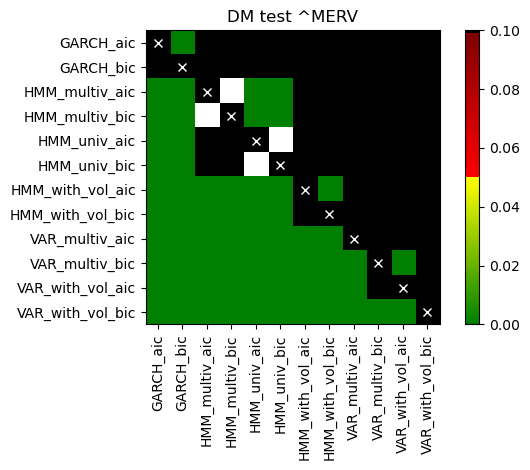

GGAL.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


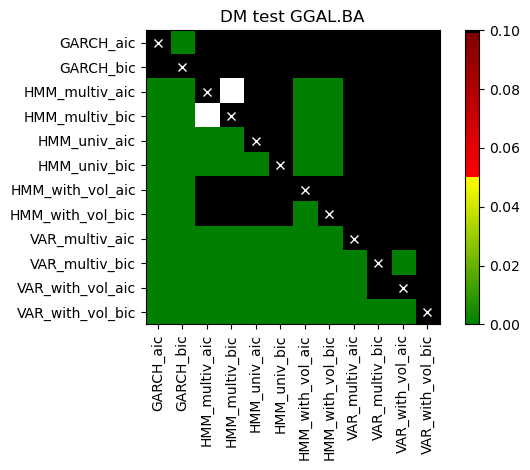

GGAL


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


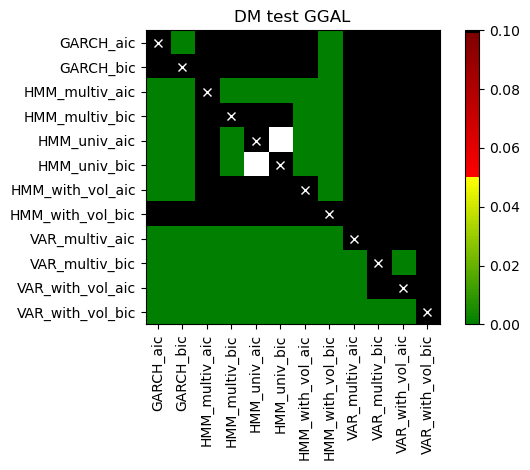

YPFD.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


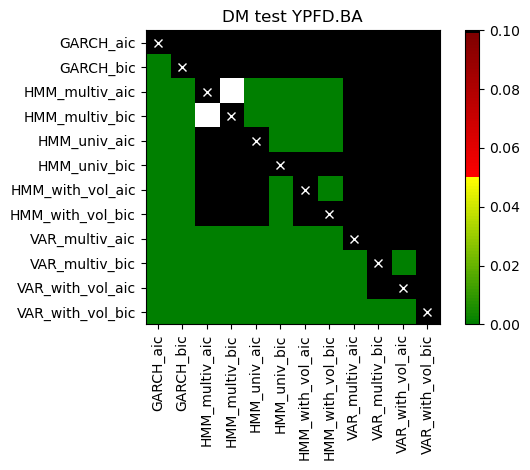

YPF


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


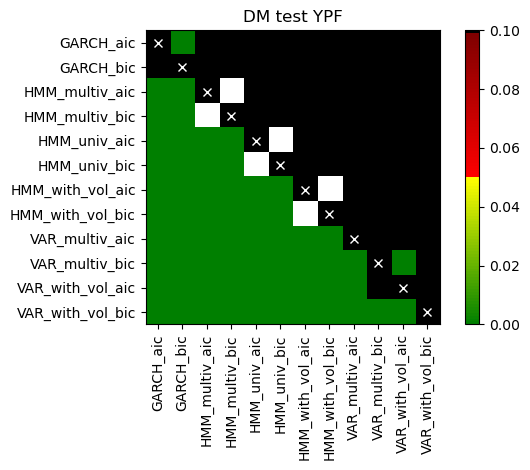

EDN.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


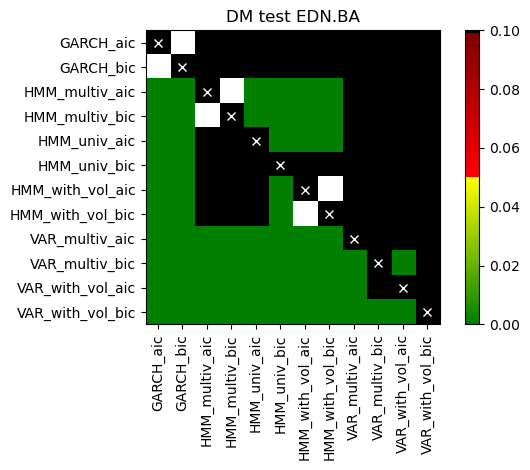

EDN


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


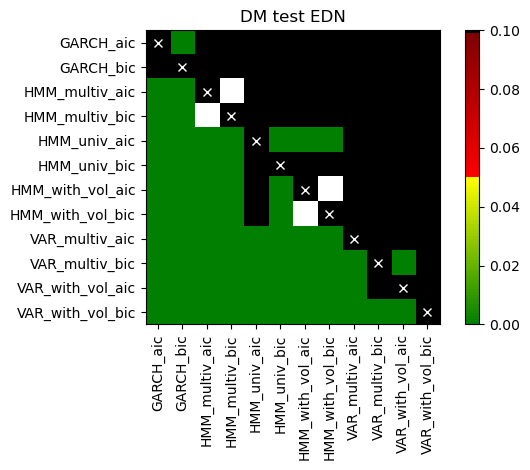

BMA.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


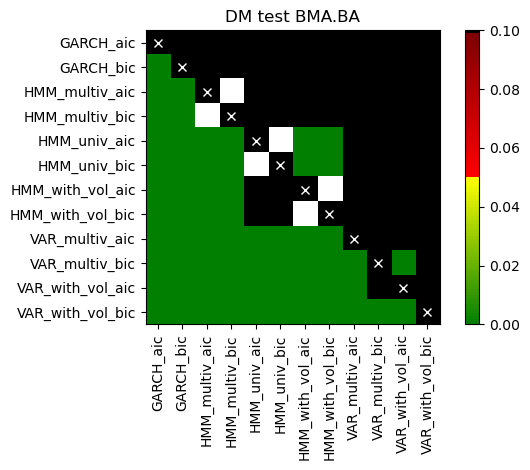

BMA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


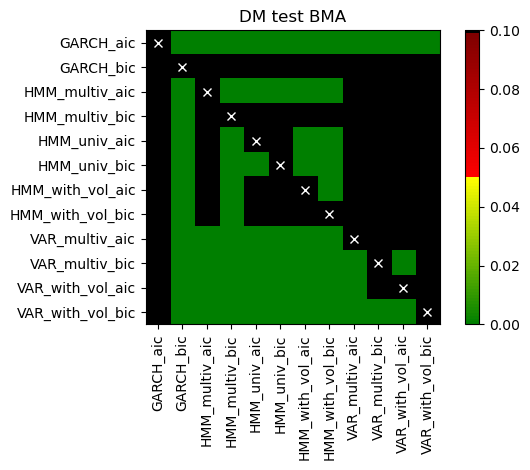

BBAR.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


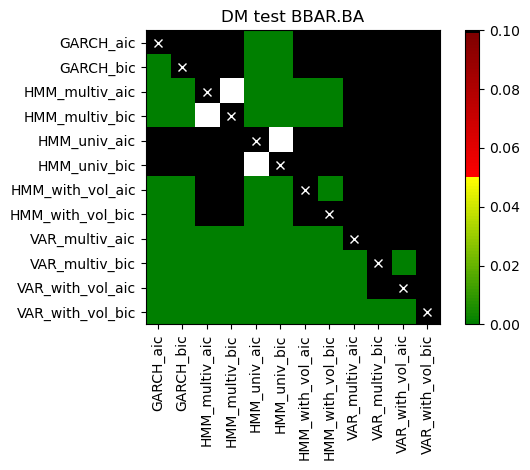

BBAR


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


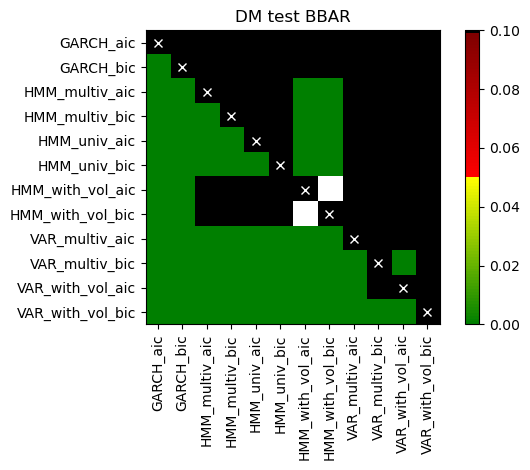

In [23]:
dmroute=os.path.join(graphsroute, "DM")
gwroute=os.path.join(graphsroute, "GW")

for stock in forecasts_by_stock.keys():
    print(stock)
    real_values=subset_of_columns(df_test, f"{stock}_log_rets")
    forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"__{stock}")   

    plot_multivariate_DM_test(real_price=real_values, 
                            forecasts=forecasts.fillna(0), 
                            title=f"DM test {stock}",
                            savefig=True,
                            path=dmroute)

In [29]:
residuals_by_stock

{'^MERV':             GARCH_aic__^MERV  GARCH_bic__^MERV  HMM_multiv_aic__^MERV  \
 2023-06-01          0.026022          0.026022                    NaN   
 2023-06-02         -0.005477         -0.005477                    NaN   
 2023-06-05          0.016149          0.016149               0.016408   
 2023-06-06          0.044972          0.044972               0.048071   
 2023-06-07         -0.005297         -0.005297              -0.006555   
 ...                      ...               ...                    ...   
 2023-11-24          0.030702          0.033118               0.033384   
 2023-11-27         -0.076841         -0.069801              -0.059747   
 2023-11-28         -0.078839         -0.078508              -0.050694   
 2023-11-29          0.013552          0.013598               0.010996   
 2023-11-30               NaN               NaN               0.018015   
 
             HMM_multiv_bic__^MERV  HMM_univ_aic__^MERV  HMM_univ_bic__^MERV  \
 2023-06-01          

In [63]:
metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

for criteria, dictionary in aggregating_dict.items():
    for model, dataframe in dictionary.items():
        metrics_df.loc["mse", f"{criteria}_{model}"] = (
            (dataframe**2).mean().mean()
        )
        metrics_df.loc["meanabs", f"{criteria}_{model}"] = (
            dataframe.abs().mean().mean()
        )
        metrics_df.loc["medianabs", f"{criteria}_{model}"] = (
            (dataframe.abs()).median().median()
        )

metrics_df = metrics_df * 100
metrics_df

,aic_GARCH,aic_HMM_univ,aic_HMM_multiv,aic_VAR_multiv,aic_VAR_with_vol,bic_GARCH,bic_HMM_univ,bic_HMM_multiv,bic_VAR_multiv,bic_VAR_with_vol
mse,6.653008e+06,0.153527,0.176854,0.293429,0.417043,6.653008e+06,0.171918,0.184005,0.431818,0.460903
meanabs,7.075074e+02,2.899991,3.042162,2.460573,2.844710,7.075155e+02,2.990630,3.096038,3.099160,3.216367
medianabs,2.272801e+00,2.207734,2.220856,1.758667,2.130095,2.284190e+00,2.292984,2.380128,2.227783,2.206785


In [64]:
for criteria in ["aic", "bic"]:
    print(criteria)
    filtered_columns = [col for col in metrics_df.columns if criteria in col]
    for metric in metrics_df.index:
        print(metric)
        print(metrics_df[filtered_columns].loc[metric].idxmin())
        print(np.round(metrics_df[filtered_columns].loc[metric].min(), 5))
        print()
    print()

aic
mse
aic_HMM_univ
0.15353

meanabs
aic_VAR_multiv
2.46057

medianabs
aic_VAR_multiv
1.75867


bic
mse
bic_HMM_univ
0.17192

meanabs
bic_HMM_univ
2.99063

medianabs
bic_VAR_with_vol
2.20679




In [ ]:
DM(p_real=0,)